In [1]:
import pandas as pd
import numpy as np
import joblib
import os 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

np.random.seed(100)
# os.chdir("/spiral_analytics")

scaler = StandardScaler()

In [2]:
def drop_cols(df):
    
    return df.drop(["z_pos", "pressure", "grip_angle", "test_id"], axis=1)
    
def augment_data(input_data, spiral_radius, invert_y=True):
    if invert_y:
        data_aug = input_data.assign(
            x_pos=(input_data["x_pos"] - spiral_radius) / spiral_radius,
            y_pos=(spiral_radius - input_data["y_pos"]) / spiral_radius
        )
    else:
        data_aug = input_data.assign(
            x_pos=(input_data["x_pos"] - spiral_radius) / spiral_radius,
            y_pos=(input_data["y_pos"] - spiral_radius) / spiral_radius
        )
        
    data_aug = data_aug.assign(time = (data_aug["time"] - min(data_aug["time"]))/1000)
    data_aug = data_aug.assign(magnitude=np.linalg.norm(data_aug[["x_pos", "y_pos"]], axis=1))
    
    # plt.plot(data_aug["time"], data_aug["theta"])
    # plt.show()

    data_aug = data_aug.assign(distance = data_aug["magnitude"].diff())
    turn_count = 0
    if data_aug.loc[0, "y_pos"] < 0:
        turn_count -= 1
    
    turns = np.array([turn_count])
    angles = np.array([])
    for row_idx in data_aug.index:
        pos = data_aug.loc[row_idx, ["x_pos", "y_pos"]].values
        if row_idx > 0:
            prev_pos = data_aug.loc[row_idx-1, ["x_pos", "y_pos"]].values
            if pos[0] > 0 and prev_pos[0] > 0 and prev_pos[1] >= 0 > pos[1]:
                turn_count -= 1  # anit-clockwise crossing of positive x-axis
            elif pos[0] > 0 and prev_pos[0] > prev_pos[1] <= 0 < pos[1]:
                turn_count += 1  # clockwise crossing of positive x-axis
            turns = np.append(turns, turn_count)
            
        atan_result = np.arctan2(pos[1], pos[0])
    
        if atan_result > 0:
            angle = atan_result + 2*np.pi*turn_count
        else:
            angle = atan_result + 2*np.pi*(turn_count+1)
            
        
        angles = np.append(angles, angle)
            
    data_aug = data_aug.assign(
        turns = turns,
        theta = angles
    )
    
    data_aug = data_aug.assign(
        error=((data_aug["theta"] / (2 * np.pi * 3)) - data_aug["magnitude"]) * data_aug["theta"],
        angular_velocity = data_aug["theta"].diff() / data_aug["time"].diff()
    )
    return data_aug

def create_feature(spiral_data):
    spiral_data: pd.DataFrame
    # spiral_data = spiral_data.copy().drop(["x_pos", "y_pos"], axis=1)
    mean_values = np.mean(spiral_data, axis=0)
    
    # rms_vals = np.sqrt(np.mean(spiral_data**2, axis=0))
    # max_values = np.max(spiral_data, axis=0)
    
    # # feature 
    # print(max_values["time"])
    
    # feature is max time
    # feature = np.array([max_values["time"], mean_values["error"], mean_values["angular_velocity"]])
    feature = np.array(np.concatenate([mean_values.values,]))
    return feature

(9,)


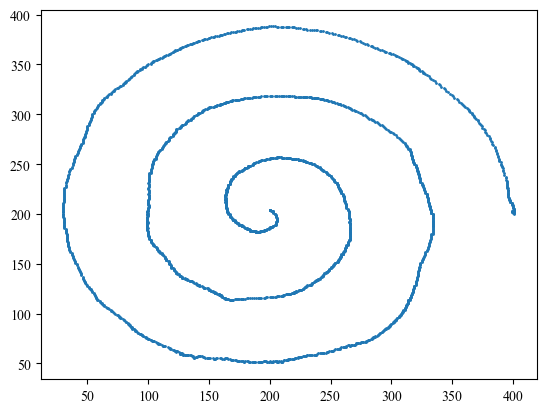

In [13]:
ids = np.random.permutation(range(25))
        
# for i in range(2):
file_path = "hw_dataset/control/C_0001.txt"
# X ; Y; Z; Pressure; GripAngle; Timestamp; Test ID
test_data = pd.read_csv(file_path, sep=";", names=["x_pos", "y_pos", "z_pos", "pressure", "grip_angle", "time", "test_id"])
static_data = test_data.loc[test_data["test_id"] == 0]
dynamic_data = test_data.loc[test_data["test_id"] == 1]

static_data_aug = drop_cols(static_data)
static_data_aug = augment_data(static_data_aug, spiral_radius=200)
# print(static_data_aug.tail(), static_data_aug.columns)
spiral_feature = create_feature(static_data_aug)
print(spiral_feature.shape)

plt.figure()
plt.scatter(static_data["x_pos"], static_data["y_pos"], s=1)

plt.savefig("spiral_control_1.png", bbox_inches='tight')
plt.show()

# plt.plot(static_data_aug["time"], static_data_aug["theta"])
# plt.show()

# Load spiral dataset

In [4]:
col_names = ["x_pos", "y_pos", "z_pos", "pressure", "grip_angle", "time", "test_id"]

feature_df = pd.DataFrame(data=None, columns=(["label", "set_id"] + [f"predictor_{idx}" for idx in range(len(spiral_feature))]))

base_path = "hw_dataset"
times = []
for dataset in ("control", "parkinson"):
    file_names = os.listdir(f"hw_dataset/{dataset}")
    file_paths = [os.path.join(base_path, dataset, file_name) for file_name in file_names if ".txt" in file_name]
    for idx, file_path in enumerate(file_paths):
        test_data = pd.read_csv(file_path, sep=";", names=col_names)
        static_data = test_data.loc[test_data["test_id"] == 0]
        if dataset == "parkinson":
            times.append(max(static_data["time"] - min(static_data["time"])))
        static_data_aug = drop_cols(static_data)
        static_data_aug = augment_data(static_data_aug, spiral_radius=200)
        spiral_feature = create_feature(static_data_aug)
        if dataset == "parkinson":
            label = 1
        else:
            label = 0
            
        feature_df.loc[len(feature_df)] = np.append([label, idx], spiral_feature)

29.53164


# sort into training / validation datasets 

In [5]:
def partition_data(df, train_split, even_classes=True):

    control_count = sum(df["label"] == 0)
    nd_count = sum(df["label"] == 1)
    if even_classes:
        class_count = min(control_count, nd_count)
        control_train_ids = np.random.permutation(range(control_count))[:int(class_count*train_split)]
        nd_train_ids = np.random.permutation(range(nd_count))[:int(class_count*train_split)]
    else:
        control_train_ids = np.random.permutation(range(control_count))[:int(control_count*train_split)]
        nd_train_ids = np.random.permutation(range(nd_count))[:int(nd_count*train_split)]
    
    control_val_ids = np.array([idx for idx in range(control_count) if not np.isin(idx, control_train_ids)])
    nd_val_ids = np.array([idx for idx in range(nd_count) if not np.isin(idx, nd_train_ids)])
    
    train_df = df.loc[np.logical_or(
        np.logical_and((df["label"] == 0), np.isin(df["set_id"], control_train_ids)), 
        np.logical_and((df["label"] == 1), np.isin(df["set_id"], nd_train_ids)))]
    
    val_df = df.loc[np.logical_or(
        np.logical_and((df["label"] == 0), np.isin(df["set_id"], control_val_ids)), 
        np.logical_and((df["label"] == 1), np.isin(df["set_id"], nd_val_ids)))]
    
    return train_df, val_df

In [7]:
from sklearn import svm

linear_accuracies = []
mlp_accuracies = []
svm_accuracies = []

conf_matrix_array = np.empty([2, 2, 0])

best_cost = 100
best_model = None
lr = LinearRegression()
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(11, 11), random_state=1, max_iter=int(5e6))
# class_weight={0: 10}
# svm_clf = svm.SVC(kernel="poly",degree=2, class_weight={0:25, 1:15})
svm_clf = svm.SVC(kernel="rbf", class_weight={0:25, 1:15})

for fold in range(500):
    train_set, val_set = partition_data(feature_df, 0.8, even_classes=False)
    
    train_data = train_set.drop(["label", "set_id"], axis=1)
    val_data = val_set.drop(["label", "set_id"], axis=1)
    
    # print(f"control_count: {sum(train_set.label == 0)}, p count: {sum(train_set.label == 1)}")
    
    # train_data = scaler.fit_transform(train_data)
    # val_data = scaler.transform(val_data)
    linear_model = lr.fit(train_data, train_set["label"])
    svm_clf.fit(train_data, train_set.label)
    mlp.fit(scaler.fit_transform(train_data), train_set.label)
    
    
    mlp_acc = mlp.score(scaler.fit_transform(val_data), val_set.label)
    mlp_accuracies.append(mlp_acc)
    
    svm_acc = svm_clf.score(val_data, val_set.label)
    svm_accuracies.append(svm_acc)
    
    predictions = linear_model.predict(val_data)
    classification = [val > 0.5 for val in predictions]
    
    cost = []
    for idx, val in enumerate(predictions):
        if val_set.label.values[idx] == 0:
            cost.append(val)
        else:
            cost.append(-val)
    #         
    # print(linear_model.predict(val_data), val_set.label)
    cm = confusion_matrix(classification, val_set.label)
    conf_matrix_array = np.append(conf_matrix_array, np.expand_dims(cm, axis=2), axis=2)
            
    if np.linalg.norm(cost) < best_cost:
        best_model = linear_model
        best_cost = sum(cost)
        
    accuracy = (np.mean(np.equal(classification, val_set.label)))
    linear_accuracies.append(accuracy)

In [8]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

print(f"Mean regression accuracy: {np.mean(linear_accuracies)*100}%")
train_set, val_set = partition_data(feature_df, 0.8)
val_data = val_set.drop(["label", "set_id"], axis=1)
opt_predictions = best_model.predict(val_data)
opt_classification = [val > 0.5 for val in opt_predictions]
accuracy = (np.mean(np.equal(opt_classification, val_set.label)))
cm = confusion_matrix(opt_classification, val_set.label)


print(np.sum(conf_matrix_array, axis=2))

df_cm = pd.DataFrame(np.sum(conf_matrix_array, axis=2), index = ["control", "parkinons"],
                  columns = ["control", "parkinons"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["control", "parkinsons"])
plt.show()

print(f"Mean mlp accuracy: {np.mean(mlp_accuracies)*100}%")
opt_predictions = mlp.predict(scaler.fit_transform(val_data))
opt_classification = [val > 0.5 for val in opt_predictions]
accuracy = (np.mean(np.equal(opt_classification, val_set.label)))
print(f"Best accuracy: {accuracy*100}%")
cm = confusion_matrix(opt_classification, val_set.label)
print(cm)

print(f"Mean svm accuracy: {np.mean(svm_accuracies)*100}%")
opt_predictions = svm_clf.predict(val_data)
opt_classification = [val > 0.5 for val in opt_predictions]
accuracy = (np.mean(np.equal(opt_classification, val_set.label)))
print(f"Best accuracy: {accuracy*100}%")
cm = confusion_matrix(opt_classification, val_set.label)
print(cm)

print(train_set.shape, val_set.shape)

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
os.chdir("/Users/benhoskings/Documents/Pycharm/Hero_Monitor")
joblib.dump(best_model, os.path.join("data/linear_regression_model.joblib"))